In [1]:
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
import numpy as np
from scipy import stats

import pandas as pd
import pymc3 as pm

import matplotlib.pyplot as pl
import arviz as az

In [2]:
%matplotlib inline

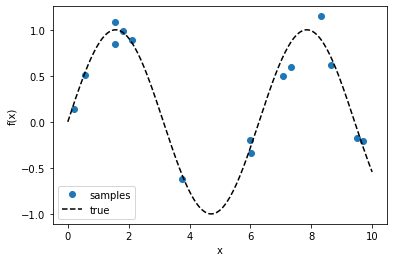

In [3]:
np.random.seed(42)
x = np.random.uniform(0, 10 ,size=15)
y = np.random.normal(np.sin(x), 0.1)
pl.plot(x, y, 'o', label='samples')
true_x = np.linspace(0, 10, 200)
pl.plot(true_x, np.sin(true_x), 'k--', label='true')
pl.xlabel('x')
pl.ylabel('f(x)',)
pl.legend();

In [4]:
X =x[:, None]

In [5]:
with pm.Model() as mreg:
    #hyperprior for lengthscale kernel parameter
    ℓ = pm.Gamma('ℓ', 2, 0.5)
    #instantiate covariance function
    cov = pm.gp.cov.ExpQuad(1, ls=ℓ)
    #instantiate a GP prior
    gp = pm.gp.Marginal(cov_func=cov)
    #prior
    ϵ = pm.HalfNormal('ϵ', 25)
    #likelihood
    y_pred = gp.marginal_likelihood('y_pred', X=X, y=y, noise=ϵ)

In [6]:
trace_reg = pm.sample(draws=1000, tune=1000, model=mreg)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ϵ, ℓ]
Sampling 4 chains: 100%|██████████| 8000/8000 [00:28<00:00, 281.10draws/s]


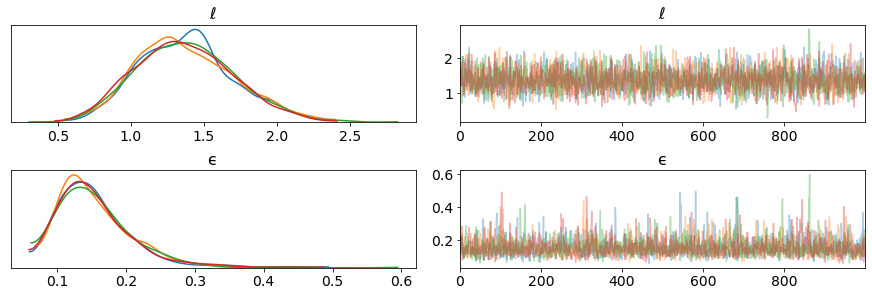

In [7]:
az.plot_trace(trace_reg);

In [9]:
X_new = np.linspace(np.floor(x.min()), np.ceil(x.max()), 100)[:, None]

In [12]:
with mreg:
    f_pred = gp.conditional('f_pred', X_new)
    pred_samples = pm.sample_posterior_predictive(trace_reg, vars=[f_pred], samples=82)

100%|██████████| 82/82 [00:03<00:00, 31.38it/s]


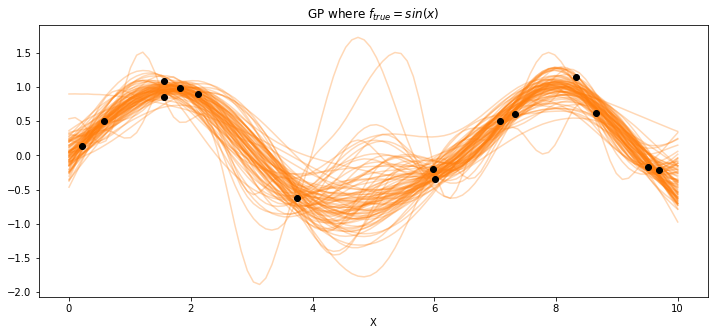

In [13]:
_, ax = pl.subplots(figsize=(12, 5))
ax.plot(X_new, pred_samples['f_pred'].T, 'C1-', alpha=0.3)
ax.plot(X, y, 'ko')
ax.set_xlabel('X')
ax.set_title('GP where $f_{true} = sin(x)$');

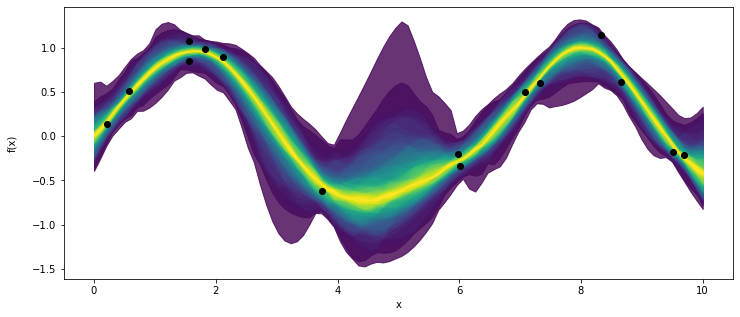

In [14]:
_, ax = pl.subplots(figsize=(12, 5))
pm.gp.util.plot_gp_dist(ax, pred_samples['f_pred'], X_new, palette='viridis', 
                        plot_samples=False)
ax.plot(X, y, 'ko')
ax.set_xlabel('x')
ax.set_ylabel('f(x)', labelpad=15);

Compute the mean and standard deviation vectors:

In [12]:
point={'ℓ': trace_reg['ℓ'].mean(), 'ϵ': trace_reg['ϵ'].mean()}
μ, var = gp.predict(X_new, diag=True, point=point)
σ = var**0.5

Text(0.5, 0, 'X')

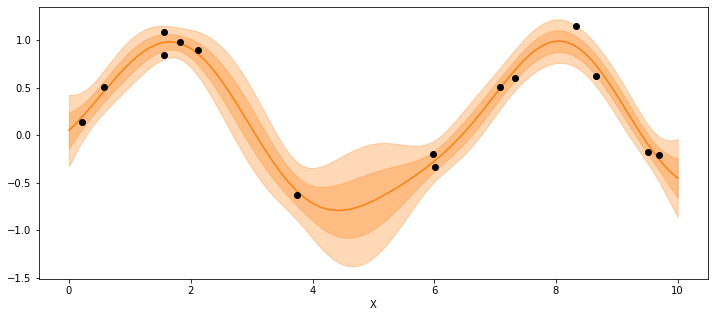

In [13]:
_, ax = pl.subplots(figsize=(12, 5))
ax.plot(X_new, μ, 'C1')
ax.fill_between(X_new.flatten(), μ-σ, μ+σ, color='C1', alpha=0.3)
ax.fill_between(X_new.flatten(), μ-2*σ, μ+2*σ, color='C1', alpha=0.3)
ax.plot(X, y, 'ko')
ax.set_xlabel('X')